<a href="https://colab.research.google.com/github/chldnjstjr/Backup/blob/master/BiLSTM_SteamReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://wikidocs.net/94748

# Google Colab 내에서 패키지 영구적으로 설치하기
[출처](https://teddylee777.github.io/colab/colab%EC%97%90%EC%84%9C-python%ED%8C%A8%ED%82%A4%EC%A7%80%EB%A5%BC-permanently-%EC%9D%B8%EC%8A%A4%ED%86%A8%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95)

In [1]:
#시작 전 아래 코드 실행!
import os, sys  
from google.colab import drive  
drive.mount('/content/drive')   

pg_path = '/content/packages'

os.symlink('/content/drive/My Drive/Colab Notebooks', pg_path)  
sys.path.insert(0, pg_path)  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#모델 저장 및 호출

[출처](https://http://daddynkidsmakers.blogspot.com/2019/06/blog-post_5.html)

In [2]:
#저장
from keras.models import load_model
from google.colab import files
files.download('best_model.h5') #from colab to browser download

FileNotFoundError: ignored

In [3]:
#호출
from keras.models import load_model
model = load_model('/content/drive/My Drive/best_model.h5')

# 환경 및 데이터 로드

In [2]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 24.07 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 2.6 MB/s 
     |████████████████████████████████| 448 kB 56.3 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-01-18 14:14:30--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loc

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
#Data load
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7f0689e1c490>)

# 전처리 & EDA

In [5]:
#해당 데이터에는 열제목이 별도로 없습니다. 그래서 임의로 두 개의 열제목인 'label'과 'reviews'를 추가
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) #전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


In [6]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [7]:
#각 열에서 중복을 제외한 샘플의 수를 카운팅
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [8]:
#reviews 열에서 중복 108개 제외하면 99,892개. 중복 샘플 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True) #reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수:', len(total_data))

총 샘플의 수: 99892


In [9]:
#Null 값 유무 확인
print(total_data.isnull().values.any())

False


In [10]:
#훈련 데이터와 테스트 데이터 분리하기
train_data, test_data=train_test_split(total_data, test_size=0.25, random_state=42)
print('훈련용 리뷰의 개수:', len(train_data))
print('테스트용 리뷰의 개수:', len(test_data))

훈련용 리뷰의 개수: 74919
테스트용 리뷰의 개수: 24973


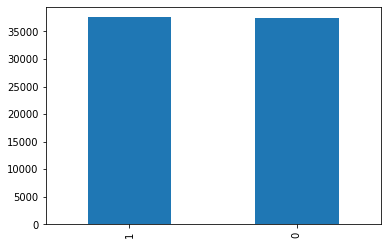

In [11]:
#레이블의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name='count'))
#두 레이블 모두 약 3만 7천개로 50:50 비율

   label  count
0      0  37376
1      1  37543


In [13]:
#데이터 정제
#정규 표현식을 사용하여 한글을 제외하고 모두 제거. 

train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


In [14]:
#테스트 데이터에도 똑같이 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


In [15]:
#불용어 처리
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [16]:
#토큰화
mecab = Mecab() 

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [17]:
#단어 길이 분포 확인
#긍/부정 리뷰에 주로 어떤 단어가 많이 등장하는지 각 단ㅇ의 빈도수를 계산해보자. 각 레이블에 따라 별도로 단어들의 리스트 저장
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [18]:
#Counter()를 사용하여 빈도수 카운트
#우선 부정 리뷰에 대해 빈도수가 높은 상위 20개 단어 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [19]:
#마찬가지로 긍정 리뷰에 대해 빈도수 상위 20개 단어 출력
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


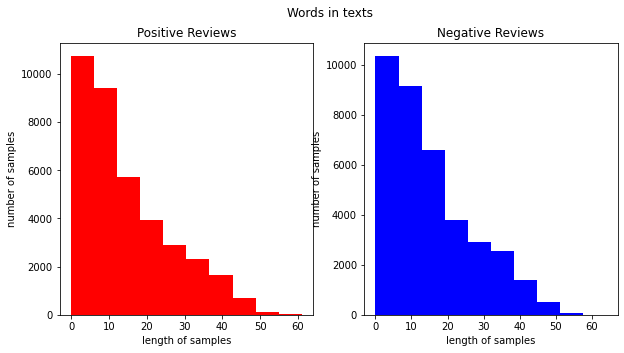

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [21]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [22]:
#정수 인코딩
#훈련 데이터에 대해 단어 집합을 만들자
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


In [24]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18941


In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
print(X_train[:3])

[[495, 7, 35, 87, 149, 2429, 599, 26, 8, 70, 47, 235, 111, 38, 44, 52], [161, 300, 18, 20, 63, 3582, 985, 6, 56], [7, 17, 1476, 4]]


In [27]:
print(X_test[:3])

[[728, 34, 16, 431, 52, 106, 132, 99, 6461, 453], [4527, 687, 835, 712, 792, 108, 4, 1779, 95, 370, 3518, 81, 558, 1904, 4189, 262, 169, 61, 25, 363, 35, 87, 974, 19, 6294, 6422], [1792, 806, 685, 49, 23, 349]]


리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


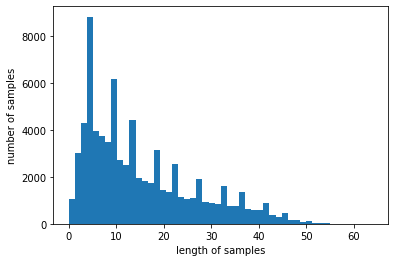

In [28]:
#패딩
#서로 다른 샘플들의 길이를 동일하게!
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [30]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


In [31]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [32]:
#BiLSTM으로 스팀 리뷰 감성 분류하기
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [33]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(1, activation='sigmoid'))

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [35]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.5240 - acc: 0.7438
Epoch 00001: val_acc improved from -inf to 0.76395, saving model to best_model.h5
235/235 [==============================] - 186s 769ms/step - loss: 0.5240 - acc: 0.7438 - val_loss: 0.4940 - val_acc: 0.7639
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.4322 - acc: 0.8039
Epoch 00002: val_acc improved from 0.76395 to 0.78764, saving model to best_model.h5
235/235 [==============================] - 174s 739ms/step - loss: 0.4322 - acc: 0.8039 - val_loss: 0.4601 - val_acc: 0.7876
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.4058 - acc: 0.8196
Epoch 00003: val_acc did not improve from 0.78764
235/235 [==============================] - 174s 739ms/step - loss: 0.4058 - acc: 0.8196 - val_loss: 0.4611 - val_acc: 0.7857
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.3834 - acc: 0.8313
Epoch 00004: val_acc did not improve from 0.

In [36]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 26s 32ms/step - loss: 0.4624 - acc: 0.7866
테스트 정확도: 0.7866


In [37]:
#리뷰 예측
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  print("감정지수는 {:.0f}점입니다.".format(score * 100))

In [38]:
sentiment_predict('진짜 싫어!')

감정지수는 20점입니다.


In [39]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
from sklearn.preprocessing import LabelEncoder

# Web App with Streamlit

In [40]:
!pip install streamlit

     |████████████████████████████████| 9.3 MB 7.1 MB/s 
     |████████████████████████████████| 111 kB 58.5 MB/s 
     |████████████████████████████████| 4.3 MB 36.2 MB/s 
     |████████████████████████████████| 164 kB 39.9 MB/s 
     |████████████████████████████████| 180 kB 45.2 MB/s 
     |████████████████████████████████| 76 kB 3.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 127 kB 43.1 MB/s 
     |████████████████████████████████| 792 kB 49.6 MB/s 
     |████████████████████████████████| 374 kB 44.4 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=266336a8bbaea3c43358032dd74f3435bc360ae8e6ddeac3520365d5f7e0198d
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      S

In [41]:
!pip install pyngrok

     |████████████████████████████████| 745 kB 8.3 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=d80a92519121c88b0ad09ac67e21e1a52a560b9b1b16fa98f3d298348f1a5040
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [42]:
!pip install readtime

  Created wheel for readtime: filename=readtime-1.1.1-py3-none-any.whl size=7215 sha256=c074493c9463bc46ab064f38511164d63908a3e0824d4927ec3984f37375aa99
  Stored in directory: /root/.cache/pip/wheels/f3/07/26/b5ebc2444c46fb4092bc124adce641cb84db77280dfe80fe0b
Successfully built readtime


In [43]:
!pip install textstat

     |████████████████████████████████| 101 kB 4.7 MB/s 
     |████████████████████████████████| 2.0 MB 41.1 MB/s 


In [44]:
%%writefile app.py
import streamlit as st
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyngrok import ngrok
import time
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import readtime
import textstat
import re
from konlpy.tag import Mecab
from tqdm import tqdm

mecab = Mecab() 


st.sidebar.header('꿈트리가 당신의 감정을 분석해줘요! :heart:')
nav = st.sidebar.radio('',['HOME', '감정상태 진단'])
st.sidebar.write('')
st.sidebar.write('')
st.sidebar.write('')

#CONTACT
########
expander = st.sidebar.expander('Contact')
expander.write("사용 후 피드백을 보내주시면 성능 향상에 큰 도움이 됩니다. :smiley: [G-Mail] (wriggle.2002@gmail.com), [Instagram] (https://www.instagram.com/wriggle_2)")

if nav == 'HOME':

    st.markdown("<h1 style='text-align: center; color: white; font-size:28px;'>감정기록 다이어리 앱 꿈트리</h1>", unsafe_allow_html=True)
    st.markdown("<h3 style='text-align: center; font-size:56px;'<p>&#129302;</p></h3>", unsafe_allow_html=True)
    st.markdown("<h3 style='text-align: center; color: grey; font-size:20px;'>나의 객관적인 감정 상태는?</h3>", unsafe_allow_html=True)
    """
    [![Star](https://img.shields.io/github/stars/chldnjstjr.svg?logo=github&style=social)](https://gitHub.com/chldnjstjr)
    &nbsp[![Follow](https://img.shields.io/instagram/follow/lopezyse?style=social)](https://www.instagram.com/wriggle_2)
    """
    st.markdown('___')
    st.write(':point_left: 왼쪽 [감정상태 진단] 클릭!')
    st.markdown('___')
    st.markdown("<h3 style='text-align: left; color:#F63366; font-size:18px;'><b>꿈트리는 무슨 앱인가요?<b></h3>", unsafe_allow_html=True)
    st.write("꿈트리는 여러분이 작성한 다이어리를 분석하여 감정지수를 제공하는 앱입니다.")
    st.markdown("<h3 style='text-align: left; color:#F63366; font-size:18px;'><b>꿈트리는 누구를 위한 앱인가요??<b></h3>", unsafe_allow_html=True)
    st.write("자신의 감정 추이를 살펴보고 좋은 감정:heart:을 유지하고 싶은 분들을 위한 앱입니다!")
    st.write("모바일 앱을 열심히 개발 중입니다. 조만간 만나실 수 있어요!")

def sentiment_predict(new_sentence):
  model=load_model('best_model.h5')
  with open('tokenizer.pickle', 'wb') as handle:
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    vocab_size = total_cnt - rare_cnt + 2
    tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
    tokenizer = pickle.load(handle)
    x_1 = tokenizer.texts_to_sequences([new_sentence])
    x_1 = pad_sequences(x_1, maxlen=500)
    predictions = model.predict(x_1)[0][0]
    return predictions

def p_title(title):
    st.markdown(f'<h3 style="text-align: left; color:#F63366; font-size:28px;">{title}</h3>', unsafe_allow_html=True)

if nav == '감정상태 진단':
    st.markdown("<h4 style='text-align: center; color:grey;'> 꿈트리와 함께 당신의 감정상태를 확인해보세요! &#129302;</h4>", unsafe_allow_html=True)
    st.text('')
    p_title('감정상태 진단')
    st.text('')
    
    a_example = " "

    source = st.radio("Option",
                          ("직접 작성", "파일(.txt) 업로드"))
    st.text('')

    if source == '직접 작성':
        new_sentence = st.text_area("다이어리 또는 감정 상태를 진솔하게 작성해주세요.", max_chars=10000, value=a_example, height=330)
        if st.button('진단하기'):
            if len(new_sentence) > 10000:
                st.error('최대 글자 수 10,000자를 넘기지 말아주세요.')
            else:
                with st.spinner('분석 중입니다...'):
                    time.sleep(2)
                    nltk.download('punkt')
                    rt = readtime.of_text(new_sentence)
                    tc = textstat.flesch_reading_ease(new_sentence)
                    tokenized_words = word_tokenize(new_sentence)
                    lr = len(set(tokenized_words)) / len(tokenized_words)
                    lr = round(lr,2)
                    n_s = textstat.sentence_count(new_sentence)
                    prediction=sentiment_predict(new_sentence)
                    st.markdown('___')
                    st.text('감정지수')
                    st.write("감정지수는 {:.0f}점입니다.".format(prediction*100))
                    st.markdown('___')
                    st.text('Reading Time')
                    st.write(rt)
                    st.markdown('___')
                    st.text('Text Complexity: from 0 or negative (hard to read), to 100 or more (easy to read)')
                    st.write(tc)
                    st.markdown('___')
                    st.text('Lexical Richness (distinct words over total number of words)')
                    st.write(lr)
                    st.markdown('___')
                    st.text('Number of sentences')
                    st.write(n_s)
                    st.balloons()

    if source == '파일(.txt) 업로드':
        file = st.file_uploader('Upload your file here',type=['txt'])
        if file is not None:
            with st.spinner('분석 중입니다...'):
                    time.sleep(2)
                    stringio = StringIO(file.getvalue().decode("utf-8"))
                    new_sentence = stringio.read()
                    if len(new_sentence) > 10000:
                        st.error('최대 글자 수 10,000자를 넘기지 말아주세요.')
                    else:
                        nltk.download('punkt')
                        rt = readtime.of_text(new_sentence)
                        tc = textstat.flesch_reading_ease(new_sentence)
                        tokenized_words = word_tokenize(new_sentence)
                        lr = len(set(tokenized_words)) / len(tokenized_words)
                        lr = round(lr,2)
                        n_s = textstat.sentence_count(new_sentence)
                        st.markdown('___')
                        st.text('Reading Time')
                        st.write(rt)
                        st.markdown('___')
                        st.text('Text Complexity: from 0 or negative (hard to read), to 100 or more (easy to read)')
                        st.write(tc)
                        st.markdown('___')
                        st.text('Lexical Richness (distinct words over total number of words)')
                        st.write(lr)
                        st.markdown('___')
                        st.text('Number of sentences')
                        st.write(n_s)
                        st.balloons()
#-----------------------------------------

Writing app.py


In [45]:
!ls #확인

app.py	       install_mecab-ko_on_colab190912.sh	  README.md
best_model.h5  install_mecab-ko_on_colab_light_220111.sh  steam.txt
images	       LICENSE					  tokenizer.pickle


In [46]:
#Local 접속
!streamlit run app.py & npx localtunnel --port 8501


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.105.102.240:8501

npx: installed 22 in 5.182s
your url is: https://hard-lion-9.loca.lt
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2022-01-18 14:46:36.213990: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-18 14:46:36.980 Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/streamlit/script_runner.py", line 379, in _run_script
    exec(code, module.__dict__)
  File "/content/Mecab-ko-for-Google-Colab/app.py", line 92, in <module>
    prediction=sentiment_predict(new_sentence)
  File "/content/Mecab-ko-for-Google-Colab/app.py", line 52, in sentiment_predict
    total_cnt = len(tokenizer.word_index) # 단어의 수
UnboundLocalError: local variable 'tokenizer' referenced before assignment

  St